# Headstorm Data Science Challenge

Aim : Using geographical coordinates paired with a timestamp representing someone's birth date to determine the meteorological season in which they were born

- By: Sayeesha Sridhar 
- sayeeshs@andrew.cmu.edu
- Global MISM '20 Student 
- Heinz College of Information Systems and Public Policy
- Carnegie Mellon University

In [1]:
import pandas as pd
from datetime import datetime
import requests
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

from pathlib import Path
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot


/home/sayeesha/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
data = pd.read_csv("birthdays.csv")

In [3]:
# Load API key from a text file in the system

def read_api_key(filepath="api_key.txt"):
    
    # Feel free to modify this function if you are storing the API Key differently
    return Path(filepath).read_text().strip()

In [4]:
api_key = read_api_key()

In [5]:
data.head()

,Latitude,Longitude,Birth Date
0,41.197746,-88.15758,1524447636
1,41.488365,-87.75167,1528162636
2,40.973595,-87.57315,1517638013
3,35.314070,-116.94493,1545264278
4,50.545383,-111.17417,1545864456


Create a new dataframe with pre determined columns, the dataframe will be populated with data from the API

In [8]:
df = pd.DataFrame(columns=['maxtempF','mintempF','avgtempF','totalSnow_cm','windspeedMiles','humidity','visibility','pressure','sunrise','sunset','sunHour','precipMM','birthday'])

For each row in the given dataset, search the API with the latitude, longitude and the date to retrive weather information for that day at the specified loaction. The information retrieved includes:

- Maximum Temperature recorded
- Minimum Temperature recorded
- Average Temperature recorded
- Total snow in cms
- Wind Speed in miles
- Humidity
- Pressure
- Sunrise time
- Sunset time
- Sun Hours
- precipitation in mm


In [18]:
for index, row in data.iterrows():
    dt_object = datetime.fromtimestamp(row['Birth Date'])
    response = requests.get("https://api.worldweatheronline.com/premium/v1/past-weather.ashx?q=" +str(row['Latitude'])+"," +str(row['Longitude'])+"&date="+ str(dt_object.date()) + "&key=" + api_key + "&format=json")
    
    maxtempF=(response.json()['data']['weather'][0]['maxtempF'])
    mintempF=(response.json()['data']['weather'][0]['mintempF'])
    avgtempF=(response.json()['data']['weather'][0]['avgtempF'])
    totalSnow_cm=(response.json()['data']['weather'][0]['totalSnow_cm'])
    windspeedMiles=(response.json()['data']['weather'][0]['hourly'][0]['windspeedMiles'])
    humidity=(response.json()['data']['weather'][0]['hourly'][0]['humidity'])
    pressure=(response.json()['data']['weather'][0]['hourly'][0]['pressure'])
    sunrise=(response.json()['data']['weather'][0]['astronomy'][0]['sunrise'])
    sunset=(response.json()['data']['weather'][0]['astronomy'][0]['sunset'])
    sunhour=(response.json()['data']['weather'][0]['sunHour'])
    precipMM=(response.json()['data']['weather'][0]['hourly'][0]['precipMM'])

    df = df.append({"maxtempF":maxtempF,"mintempF":mintempF,"avgtempF":avgtempF,"totalSnow_cm":totalSnow_cm,"windspeedMiles":windspeedMiles,"humidity":humidity,"pressure":pressure,"sunrise":sunrise,"sunset":sunset,"sunHour":sunhour,"precipMM":precipMM,"birthday":str(dt_object.date()) }, ignore_index=True)
    

In [47]:
df.head()

,maxtempF,mintempF,avgtempF,totalSnow_cm,windspeedMiles,humidity,visibility,pressure,sunrise,sunset,sunHour,weatherDesc,precipMM,birthday,season
0,63,44,52,0,9,54,10.0,1028,0503,1840,13.4,Overcast,0,2018-04-22,Spring
1,77,58,68,0,7,66,10.0,1015,0418,1921,14.5,Clear,0,2018-06-04,Summer
2,36,23,30,0,12,34,10.0,1029,0659,1710,5.5,Cloudy,0,2018-02-03,Winter
3,62,43,52,0,5,68,10.0,1023,0652,1638,8.7,Clear,0,2018-12-19,Winter
4,23,18,20,0.2,4,89,10.0,1025,0825,1625,3,Overcast,0,2018-12-26,Winter


Let us now add a column to indicate the season

In [25]:
def birthday_season_mapper(row): 
    month = row[5:7]
    if int(month) >=3 and int(month) <=5:
        return "Spring"
    if int(month) >=6 and int(month) <=8:
        return "Summer"
    if int(month) >=9 and int(month) <=11:
        return "Fall"
    if int(month) == 12 or int(month) <=2:
        return "Winter"

df["season"] = df['birthday'].apply(birthday_season_mapper)

Convert the sunrise and sunset time to float

In [39]:
for index, row in df.iterrows():
    sunrise = datetime.strptime(row['sunrise'], "%I:%M %p")
    sunrise = datetime.strftime(sunrise, "%H:%M")
    sunset = datetime.strptime(row['sunset'], "%I:%M %p")
    sunset = datetime.strftime(sunset, "%H:%M")
    df.loc[index,'sunrise']=sunrise[0:2]+sunrise[3:]
    df.loc[index,'sunset']=sunset[0:2]+sunset[3:]


In [40]:
df.head()

,maxtempF,mintempF,avgtempF,totalSnow_cm,windspeedMiles,humidity,visibility,pressure,sunrise,sunset,sunHour,weatherDesc,precipMM,birthday,season
0,63,44,52,0,9,54,10.0,1028,0503,1840,13.4,Overcast,0,2018-04-22,Spring
1,77,58,68,0,7,66,10.0,1015,0418,1921,14.5,Clear,0,2018-06-04,Summer
2,36,23,30,0,12,34,10.0,1029,0659,1710,5.5,Cloudy,0,2018-02-03,Winter
3,62,43,52,0,5,68,10.0,1023,0652,1638,8.7,Clear,0,2018-12-19,Winter
4,23,18,20,0.2,4,89,10.0,1025,0825,1625,3,Overcast,0,2018-12-26,Winter


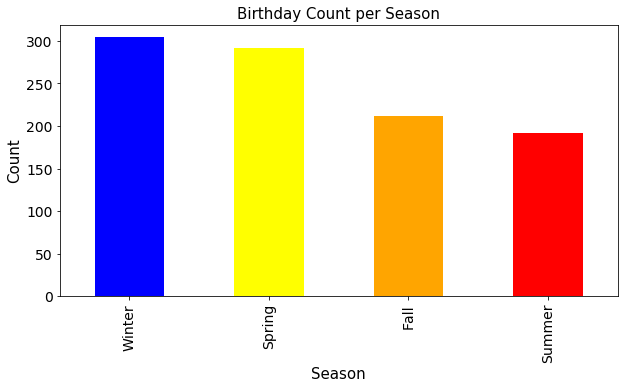

In [41]:
ax = df['season'].value_counts().plot(kind='bar', fontsize=14, figsize=(10,5),color=['blue', 'yellow','orange', 'red'])
ax.set_title('Birthday Count per Season', fontsize=15)
ax.set_xlabel('Season', fontsize=15)
ax.set_ylabel('Count', fontsize=15);

In [42]:
X = df.drop(columns=["season","birthday","visibility",'weatherDesc'])
y = df['season']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
features = list(X.columns)
features

['maxtempF',
 'mintempF',
 'avgtempF',
 'totalSnow_cm',
 'windspeedMiles',
 'humidity',
 'pressure',
 'sunrise',
 'sunset',
 'sunHour',
 'precipMM']

In [71]:
rf = RandomForestClassifier(n_estimators=30, max_depth = 8)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred, labels= ['Summer','Spring','Fall','Winter'])

array([[54,  3,  0,  0],
       [16, 86,  1,  0],
       [ 0,  2, 58,  7],
       [ 0,  0,  4, 99]])

For better interpretation, let us visualize one of the decision trees plotted by our model. Do keep in mind that this is just one random decision trees plotted among the several (30 in this case) trees in the forest created by the model. 

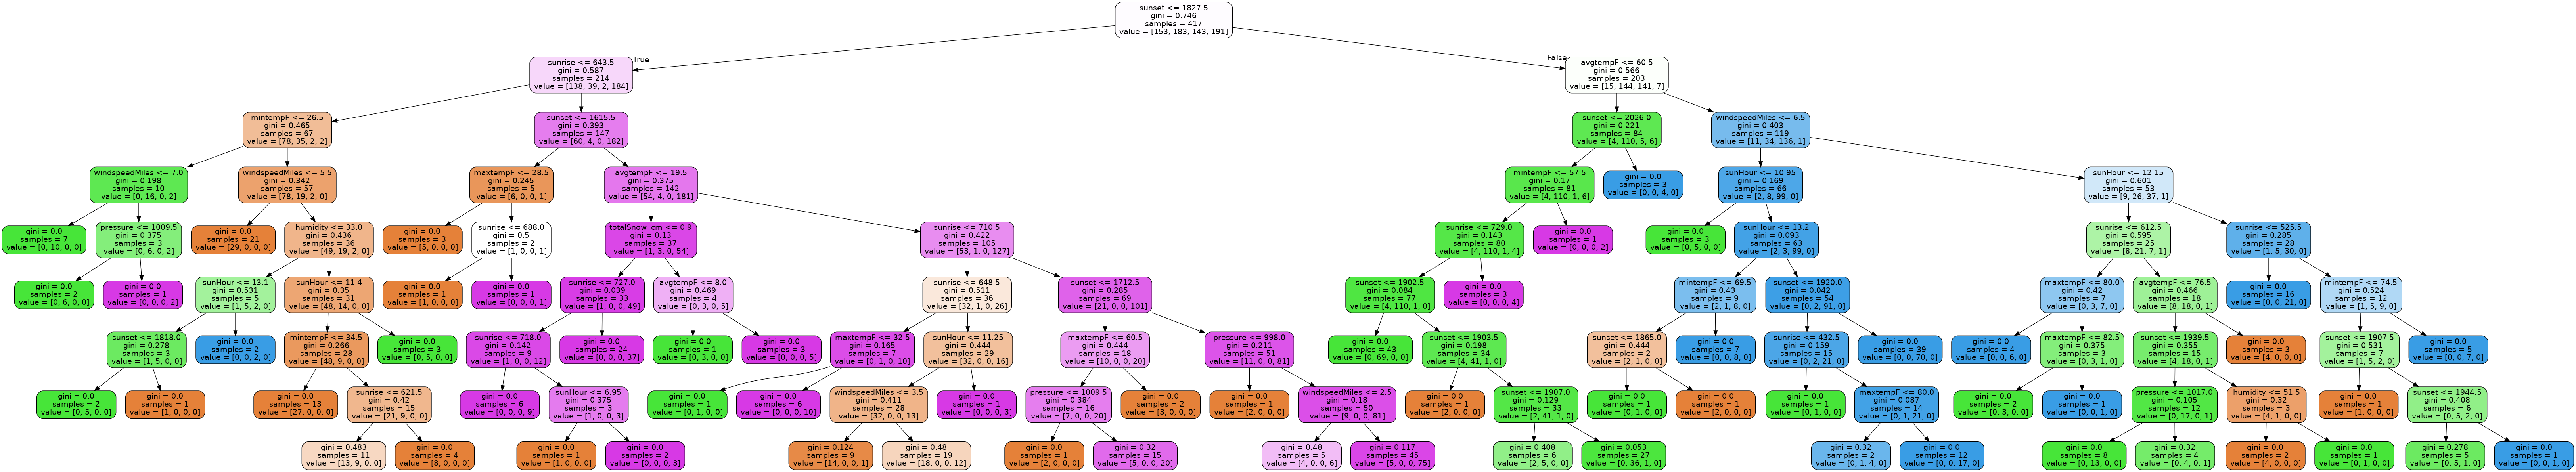

In [76]:
dot_data = StringIO()  
export_graphviz(rf.estimators_[2], out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

Let us now quantify the accuracy of our model.

In [72]:
rf.score(X_test,y_test)

0.9

Looks Great! The model now identifies the season a person is born is purely based on the weather data of the location at the time they were born with 90% accuracy!